In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import numpy as np
import imutils
import cv2

class Panaroma:

    def image_stitch(self, images, lowe_ratio=0.75, max_Threshold=2.0,match_status=False):


        (imageB, imageA) = images
        (KeypointsA, features_of_A) = self.Detect_Feature_And_KeyPoints(imageA)
        (KeypointsB, features_of_B) = self.Detect_Feature_And_KeyPoints(imageB)


        Values = self.matchKeypoints(KeypointsA, KeypointsB,features_of_A, features_of_B, lowe_ratio, max_Threshold)

        if Values is None:
            return None


        (matches, Homography, status) = Values
        result_image = self.getwarp_perspective(imageA,imageB,Homography)
        result_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB


        if match_status:
            vis = self.draw_Matches(imageA, imageB, KeypointsA, KeypointsB, matches,status)

            return (result_image, vis)

        return result_image

    def getwarp_perspective(self,imageA,imageB,Homography):
        val = imageA.shape[1] + imageB.shape[1]
        result_image = cv2.warpPerspective(imageA, Homography, (val , imageA.shape[0]))

        return result_image

    def Detect_Feature_And_KeyPoints(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect and extract features from the image
        descriptors = cv2.xfeatures2d.SIFT_create()
        (Keypoints, features) = descriptors.detectAndCompute(image, None)

        Keypoints = np.float32([i.pt for i in Keypoints])
        return (Keypoints, features)

    def get_Allpossible_Match(self,featuresA,featuresB):


        match_instance = cv2.DescriptorMatcher_create("BruteForce")
        All_Matches = match_instance.knnMatch(featuresA, featuresB, 2)

        return All_Matches

    def All_validmatches(self,AllMatches,lowe_ratio):

        valid_matches = []

        for val in AllMatches:
            if len(val) == 2 and val[0].distance < val[1].distance * lowe_ratio:
                valid_matches.append((val[0].trainIdx, val[0].queryIdx))

        return valid_matches

    def Compute_Homography(self,pointsA,pointsB,max_Threshold):


        (H, status) = cv2.findHomography(pointsA, pointsB, cv2.RANSAC, max_Threshold)
        return (H,status)

    def matchKeypoints(self, KeypointsA, KeypointsB, featuresA, featuresB,lowe_ratio, max_Threshold):

        AllMatches = self.get_Allpossible_Match(featuresA,featuresB);
        valid_matches = self.All_validmatches(AllMatches,lowe_ratio)

        if len(valid_matches) > 4:
            pointsA = np.float32([KeypointsA[i] for (_,i) in valid_matches])
            pointsB = np.float32([KeypointsB[i] for (i,_) in valid_matches])

            (Homograpgy, status) = self.Compute_Homography(pointsA, pointsB, max_Threshold)

            return (valid_matches, Homograpgy, status)
        else:
            return None

    def get_image_dimension(self,image):
        (h,w) = image.shape[:2]
        return (h,w)

    def get_points(self,imageA,imageB):

        (hA, wA) = self.get_image_dimension(imageA)
        (hB, wB) = self.get_image_dimension(imageB)
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        return vis


    def draw_Matches(self, imageA, imageB, KeypointsA, KeypointsB, matches, status):

        (hA,wA) = self.get_image_dimension(imageA)
        vis = self.get_points(imageA,imageB)

        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            if s == 1:
                ptA = (int(KeypointsA[queryIdx][0]), int(KeypointsA[queryIdx][1]))
                ptB = (int(KeypointsB[trainIdx][0]) + wA, int(KeypointsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        return vis

In [ ]:
from google.colab.patches import cv2_imshow

Enter the number of images you want to concantenate:
2
Enter the image name in order of left to right in way of concantenation:
Enter the 1 image:
foto2B.jpg
Enter the 2 image:
foto2A.jpg


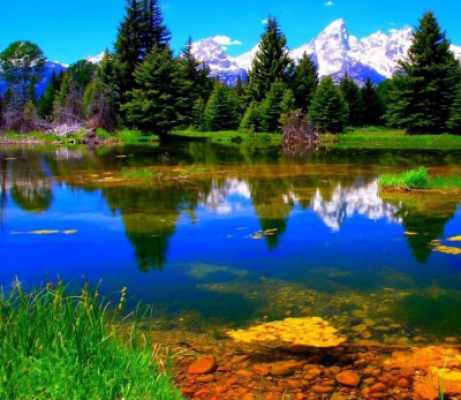

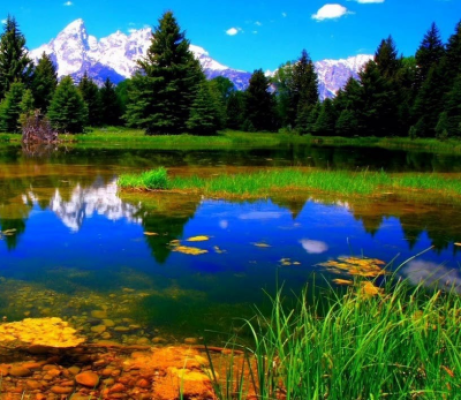

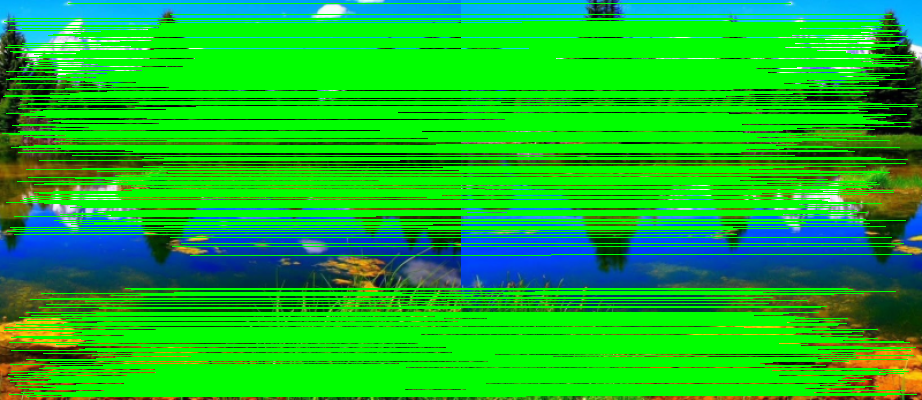

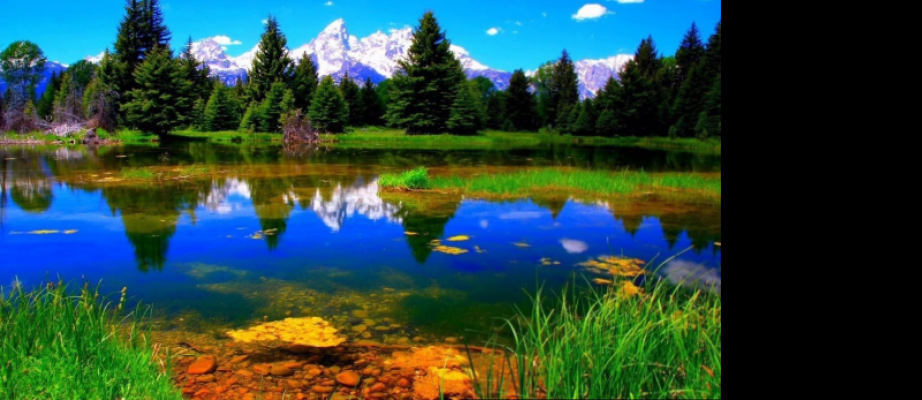

In [ ]:

import imutils
import cv2


print("Enter the number of images you want to concantenate:")
no_of_images = int(input())
print("Enter the image name in order of left to right in way of concantenation:")

filename = []

for i in range(no_of_images):
    print("Enter the %d image:" %(i+1))
    filename.append(input())

images = []

for i in range(no_of_images):
    images.append(cv2.imread(filename[i]))



for i in range(no_of_images):
    images[i] = imutils.resize(images[i], width=400)

for i in range(no_of_images):
    images[i] = imutils.resize(images[i], height=400)


panaroma = Panaroma()
if no_of_images==2:
    (result, matched_points) = panaroma.image_stitch([images[0], images[1]], match_status=True)
else:
    (result, matched_points) = panaroma.image_stitch([images[no_of_images-2], images[no_of_images-1]], match_status=True)
    for i in range(no_of_images - 2):
        (result, matched_points) = panaroma.image_stitch([images[no_of_images-i-3],result], match_status=True)


for i in range(no_of_images):
    cv2_imshow(images[i])

cv2_imshow(matched_points)
cv2_imshow(result)

#imwrite will give as cv2 imshow directly doesn't work
cv2.imwrite("Matched_points.jpg",matched_points)
cv2.imwrite("Panorama_image.jpg",result)

cv2.waitKey(0)
cv2.destroyAllWindows()